### Correlations first

In [11]:
from pandas import read_csv
import numpy as np
from pylab import plt
from copy import deepcopy
import warnings
warnings.simplefilter("ignore")
from pylab import plt
from scipy import stats

In [2]:
iclr = read_csv("../feature_extraction/iclr.csv")
neurips = read_csv("../feature_extraction/neurips.csv")

iclr.head()

,paper_id,num_equations,mean_num_new_symbols_introduced,num_overall_unique_symbols,mean_num_unique_symbols,std_of_unique_symbols,max_representational_complexity,recommendation_avg,technical_novelty_avg,empirical_novelty_avg,novelty_avg,correctness_avg,confidence_avg,presentation_avg,status
0,sKDtBKYOdIP,1057.0,0.071902,76.0,0.993377,2.847273,26.0,5.75,2.250000,2.250000,NaN,3.500000,3.500000,NaN,Reject
1,eXkhH12DTD9,160.0,0.312500,50.0,1.681250,3.363459,17.0,5.75,2.500000,2.000000,NaN,3.250000,3.750000,NaN,Poster
2,9Zx6tTcX0SE,224.0,0.294643,66.0,3.160714,3.102302,27.0,5.00,2.250000,2.750000,NaN,2.750000,3.750000,NaN,Reject
3,qhu9uX4QlP8,518.0,0.154440,80.0,2.415058,3.656891,24.0,5.25,2.250000,2.750000,NaN,3.500000,3.250000,NaN,Reject
4,zVrw4OH1Lch,531.0,0.192090,102.0,3.753296,4.000632,25.0,6.00,2.333333,2.666667,NaN,3.333333,3.333333,NaN,Poster


In [3]:
iclr_status = []
iclr_indices = []
for i, item in enumerate(iclr["status"]):
    if item in ["Poster", "Top-25%", "Top-5%"]:
        iclr_status.append(1)
        iclr_indices.append(i)
    
    elif item == "Reject":
        iclr_status.append(0)
        iclr_indices.append(i)

iclr_status = np.array(iclr_status)


In [9]:
feature_names = ["num_equations", "mean_num_new_symbols_introduced", "num_overall_unique_symbols", "mean_num_unique_symbols", "std_of_unique_symbols", "max_representational_complexity"]
iclr_corrs = [np.corrcoef(iclr[name][iclr_indices], iclr_status)[0, 1] for name in feature_names]
print("ICLR: feature-wise correlations with review scores")
for i, name in enumerate(feature_names):
    print(name, iclr_corrs[i])

ICLR: feature-wise correlations with review scores
num_equations 0.1340619790780947
mean_num_new_symbols_introduced -0.12532533931215495
num_overall_unique_symbols 0.12846995493157962
mean_num_unique_symbols 0.10142353139268036
std_of_unique_symbols 0.08630996986819423
max_representational_complexity 0.05514662763270531


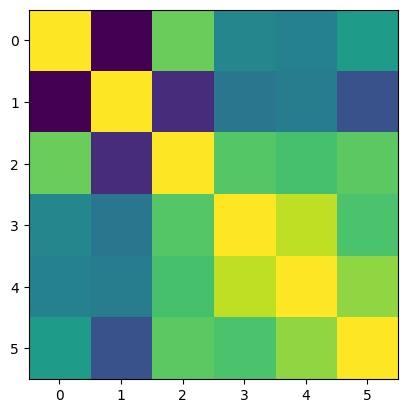

In [24]:
intra_iclr_corrs = []
for name in feature_names:
    for other_name in feature_names:
        intra_iclr_corrs.append(np.corrcoef(iclr[name][iclr_indices], iclr[other_name][iclr_indices])[0, 1])

intra_iclr_corrs = np.array(intra_iclr_corrs).reshape(6, 6)

plt.imshow(intra_iclr_corrs)
plt.show()

### Are Accept and Reject Populations different? (Hypothesis test)

#### ICLR

In [18]:
def compare_means(sample1, sample2, alpha=0.05):
    t_stat, t_pval = stats.ttest_ind(sample1, sample2)
    welch_stat, welch_pval = stats.ttest_ind(sample1, sample2, equal_var=False)
    mw_stat, mw_pval = stats.mannwhitneyu(sample1, sample2, alternative='two-sided')
    
    results = {
        "Sample Statistics": {
            "Sample 1 Mean": np.mean(sample1),
            "Sample 2 Mean": np.mean(sample2),
            "Sample 1 Size": len(sample1),
            "Sample 2 Size": len(sample2)
        },
        "Student's t-test": {
            "statistic": t_stat,
            "p-value": t_pval,
            "significant": t_pval < alpha
        },
        "Welch's t-test": {
            "statistic": welch_stat,
            "p-value": welch_pval,
            "significant": welch_pval < alpha
        },
        "Mann-Whitney U test": {
            "statistic": mw_stat,
            "p-value": mw_pval,
            "significant": mw_pval < alpha
        }
    }
    
    return results


out = {}
for name in feature_names:
    data = iclr[name][iclr_indices]
    sample1 = data[iclr_status == 1]
    sample2 = data[iclr_status == 0]
    results = compare_means(sample1, sample2)

    res = {}
    for test_name in ["Student's t-test", "Welch's t-test", "Mann-Whitney U test"]:
        res[test_name.replace("'", "")] = results[test_name]['p-value']
    out[name] = res

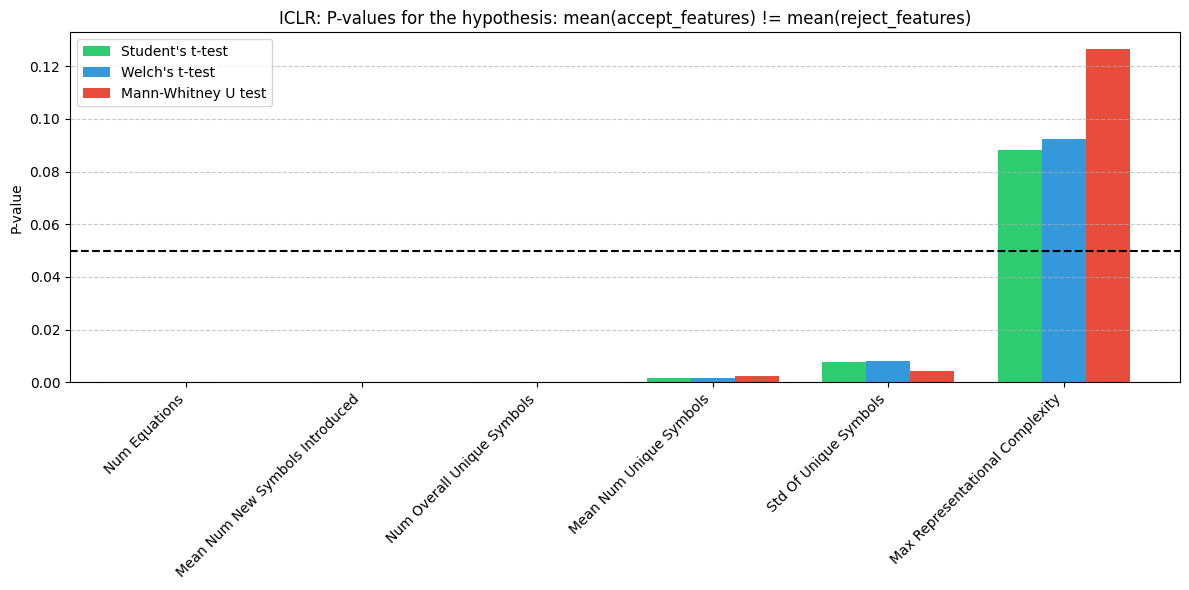

In [19]:
# Prepare data
tests = ["Students t-test", "Welchs t-test", "Mann-Whitney U test"]
features = list(data.keys())

# Create arrays for each test
students_data = [out[name]["Students t-test"] for name in feature_names]
welch_data = [out[name]["Welchs t-test"] for name in feature_names]
mann_whitney_data = [out[name]["Mann-Whitney U test"] for name in feature_names]

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Create bars
x = np.arange(len(feature_names))
width = 0.25

bars1 = ax.bar(x - width, students_data, width, label="Student's t-test", color='#2ecc71')
bars2 = ax.bar(x, welch_data, width, label="Welch's t-test", color='#3498db')
bars3 = ax.bar(x + width, mann_whitney_data, width, label="Mann-Whitney U test", color='#e74c3c')

# Customize the plot
ax.set_ylabel('P-value')
ax.set_title('ICLR: P-values for the hypothesis: mean(accept_features) != mean(reject_features)')
ax.set_xticks(x)
ax.set_xticklabels([feat.replace('_', ' ').title() for feat in feature_names], rotation=45, ha='right')
ax.legend()

# Add grid for better readability
ax.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.axhline(0.05, linestyle="--", color="black", label="p-value = 0.05")

# Adjust layout to prevent label cutoff
plt.tight_layout()
# Show plot
plt.show()

#### NeurIPs

In [20]:
out = {}
for name in feature_names:
    data = neurips[name][iclr_indices]
    sample1 = data[iclr_status == 1]
    sample2 = data[iclr_status == 0]
    results = compare_means(sample1, sample2)

    res = {}
    for test_name in ["Student's t-test", "Welch's t-test", "Mann-Whitney U test"]:
        res[test_name.replace("'", "")] = results[test_name]['p-value']
    out[name] = res


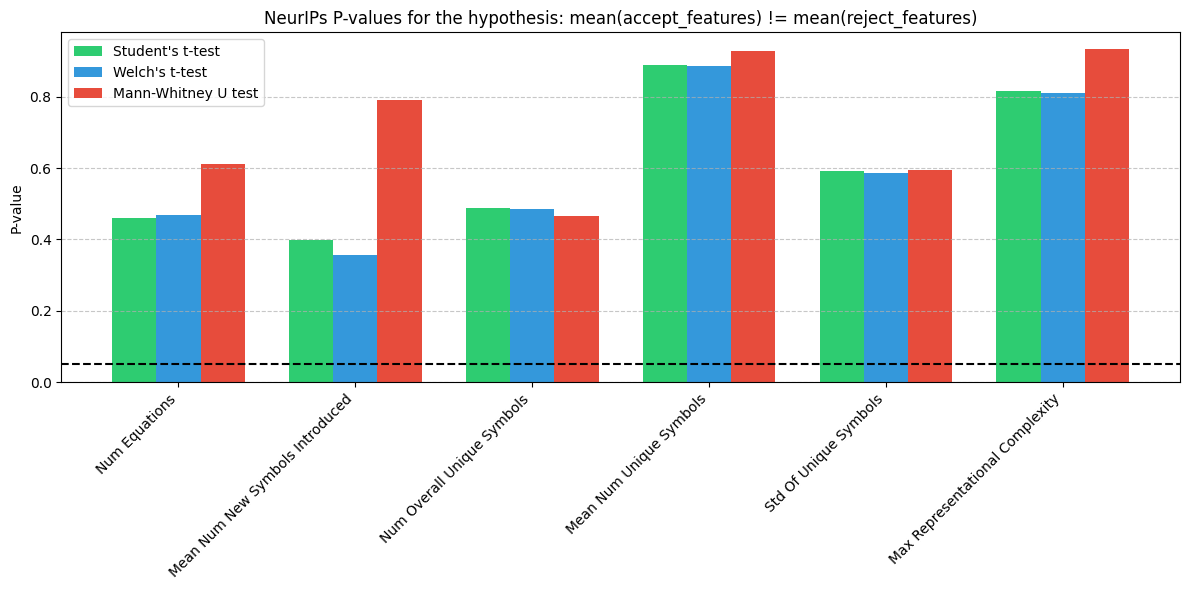

In [21]:
# Prepare data
tests = ["Students t-test", "Welchs t-test", "Mann-Whitney U test"]
features = list(data.keys())

# Create arrays for each test
students_data = [out[name]["Students t-test"] for name in feature_names]
welch_data = [out[name]["Welchs t-test"] for name in feature_names]
mann_whitney_data = [out[name]["Mann-Whitney U test"] for name in feature_names]

# Set up the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Create bars
x = np.arange(len(feature_names))
width = 0.25

bars1 = ax.bar(x - width, students_data, width, label="Student's t-test", color='#2ecc71')
bars2 = ax.bar(x, welch_data, width, label="Welch's t-test", color='#3498db')
bars3 = ax.bar(x + width, mann_whitney_data, width, label="Mann-Whitney U test", color='#e74c3c')

# Customize the plot
ax.set_ylabel('P-value')
ax.set_title('NeurIPs P-values for the hypothesis: mean(accept_features) != mean(reject_features)')
ax.set_xticks(x)
ax.set_xticklabels([feat.replace('_', ' ').title() for feat in feature_names], rotation=45, ha='right')
ax.legend()

# Add grid for better readability
ax.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.axhline(0.05, linestyle="--", color="black", label="p-value = 0.05")

# Adjust layout to prevent label cutoff
plt.tight_layout()
# Show plot
plt.show()